In [1]:
from towbintools.foundation.image_handling import read_tiff_file, check_if_zstack
from towbintools.segmentation.segmentation_tools import segment_image
from towbintools.deep_learning.architectures import models
from towbintools.deep_learning.utils.augmentation import get_prediction_augmentation
import os
import random
import matplotlib.pyplot as plt
from pytorch_toolbelt.inference.tiles import ImageSlicer
import cv2
import numpy as np
import skimage
from time import perf_counter
import torchvision.transforms as transforms
import torch

/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def resize_dim_to_closest_multiple_torch(image, multiple = 16):
    height, width = image.shape[-2:]
    print(f'Original height: {height}')
    print(f'Original width: {width}')

    # Calculate the closest multiple of 16
    new_height = round(height / multiple) * multiple
    new_width = round(width / multiple) * multiple

    print(f'New height: {new_height}')
    print(f'New width: {new_width}')

    image_tensor = torch.from_numpy(image.astype(np.int32))

    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)

    print(f'Shape of image tensor: {image_tensor.shape}')

        # Define the resize transform
    resize_transform = transforms.Resize((new_height, new_width))

    # Apply the transform
    resized_image_tensor = resize_transform(image_tensor)

    print(torch.max(resized_image_tensor))

    # Convert back to numpy array if needed
    resized_image_np = resized_image_tensor.cpu().numpy()

    return resized_image_np.astype(np.uint16)

In [3]:
model_path = "/home/spsalmon/towbintools/towbintools/deep_learning/unet_lightning_test/best_pretrained_low_lr.ckpt"
model = models.LightningPretrained.load_from_checkpoint(model_path, map_location="cpu")
model.eval()
model.freeze()

In [8]:
normalization_type = model.normalization['type']
normalization_params = model.normalization
if normalization_type == "percentile":
    preprocessing_fn = get_prediction_augmentation(normalization_type=normalization_type, lo = normalization_params['lo'], hi = normalization_params['hi'])
elif normalization_type == "mean_std":
    preprocessing_fn = get_prediction_augmentation(normalization_type=normalization_type, mean = normalization_params['mean'], std = normalization_params['std'])
elif normalization_type == "data_range":
    preprocessing_fn = get_prediction_augmentation(normalization_type=normalization_type)
else:
    preprocessing_fn = None

print(f'Preprocessing function: {preprocessing_fn}')

print(f'Model architecture: {model.hparams.architecture}')

Preprocessing function: Compose([
  NormalizePercentile(always_apply=True, p=1.0, lo=1, hi=99),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
Model architecture: UnetPlusPlus


In [13]:
image_dir = "/mnt/towbin.data/shared/igheor/20231222_Ti2_10x_rpl22AID_EV_vhp1_356_369_25C_20231222_191958_438/raw/"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".tiff")]

random_img_path = random.choice(image_paths)
print(f'Random image path: {random_img_path}')

Random image path: /mnt/towbin.data/shared/igheor/20231222_Ti2_10x_rpl22AID_EV_vhp1_356_369_25C_20231222_191958_438/raw/Time00320_Point0004_Channel470 nm,575,DIA_Seq90884.tiff


Is zstack: False
Original height: 1192
Original width: 1192
New height: 1184
New width: 1184
Shape of image tensor: torch.Size([3, 1192, 1192])
tensor(33636, dtype=torch.int32)


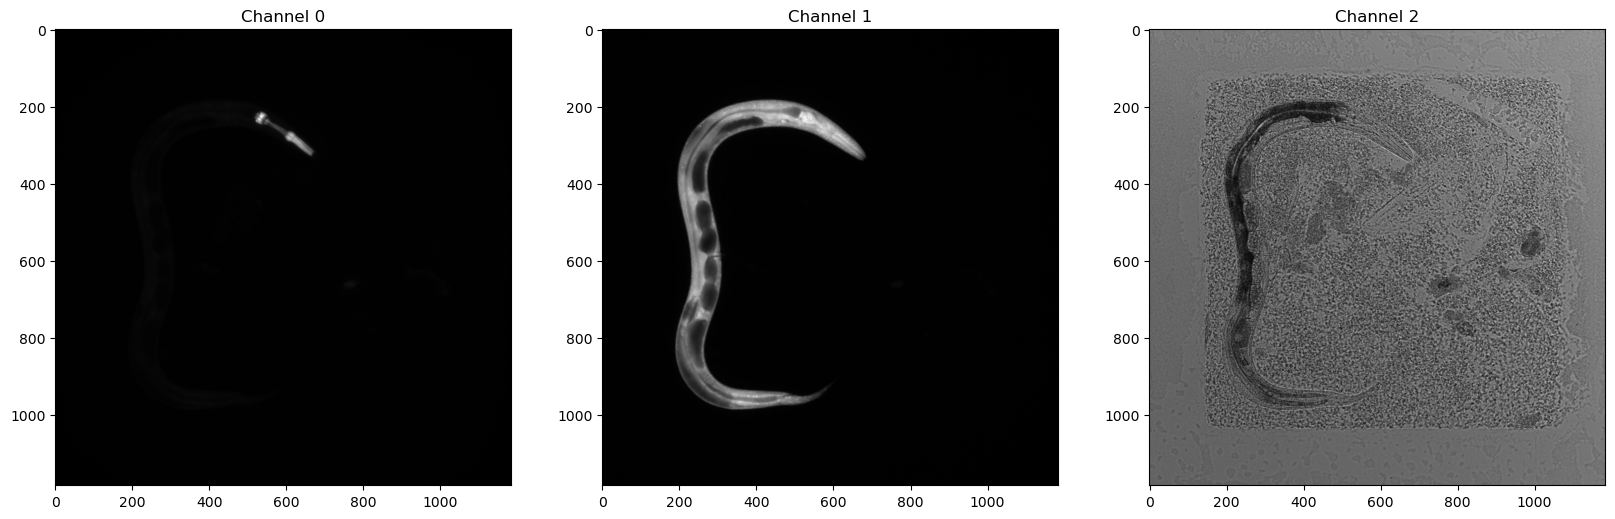

In [14]:
# Plot all the channels of the image in a grid
is_zstack = check_if_zstack(random_img_path)
print(f'Is zstack: {is_zstack}')


if is_zstack:
    image = read_tiff_file(random_img_path)
    start = perf_counter()
    image = resize_dim_to_closest_multiple_torch(image)
    end = perf_counter()
    fig, axs = plt.subplots(1, image.shape[1], figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(image[image.shape[0]//2, i, ...], cmap='gray')
        ax.set_title(f'Channel {i}')
    plt.show()
else:
    image = read_tiff_file(random_img_path)
    start = perf_counter()
    image = resize_dim_to_closest_multiple_torch(image)
    end = perf_counter()
    fig, axs = plt.subplots(1, image.shape[0], figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(image[i, ...], cmap='gray')
        ax.set_title(f'Channel {i}')

Upscaled image shape: (1192, 1192)


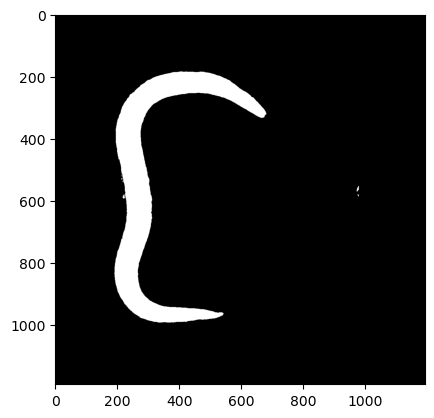

In [15]:
tiler_config = [[512, 512], [256, 256]]
# tiler_config = [[1024, 1024], [512, 512]]
tile_size = tiler_config[0]
tile_step = tiler_config[1]

# upscaled_image = resize_dim_to_closest_multiple_torch(read_tiff_file(random_img_path, [2]), multiple=16)
upscaled_image = read_tiff_file(random_img_path, [2])
# select middle plane for testing
# upscaled_image = upscaled_image[upscaled_image.shape[0]//2, ...]
print(f'Upscaled image shape: {upscaled_image.shape}')

shape = upscaled_image.shape[-2:]
tiler = ImageSlicer(image_shape=shape, tile_size=tile_size, tile_step=tile_step, weight='mean')
# tiler = None

mask = segment_image(upscaled_image.squeeze(), 'deep_learning', channels=[0], device='cpu', model=model, preprocessing_fn=preprocessing_fn, is_zstack=False, RGB=True, tiler=tiler)

plt.imshow(mask, cmap='gray')
plt.show()

Original height: 1192
Original width: 1192
New height: 1184
New width: 1184
Shape of image tensor: torch.Size([1, 1192, 1192])
tensor(4390, dtype=torch.int32)
Upscaled image shape: (1184, 1184)


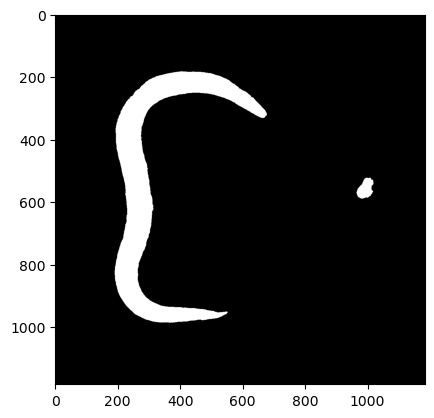

In [16]:
tiler_config = [[1024, 1024], [512, 512]]
tile_size = tiler_config[0]
tile_step = tiler_config[1]

upscaled_image = resize_dim_to_closest_multiple_torch(read_tiff_file(random_img_path, [2]), multiple=16)
# select middle plane for testing
upscaled_image = upscaled_image[upscaled_image.shape[0]//2, ...]
print(f'Upscaled image shape: {upscaled_image.shape}')

shape = upscaled_image.shape[-2:]
tiler = ImageSlicer(image_shape=shape, tile_size=tile_size, tile_step=tile_step, weight='pyramid')
tiler = None

mask = segment_image(upscaled_image, 'deep_learning', channels=[0], device='cpu', model=model, preprocessing_fn=preprocessing_fn, is_zstack=False, RGB=True, tiler=tiler)

plt.imshow(mask, cmap='gray')
plt.show()